In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')

In [2]:
### 맥락 벡터 구하기: repeat 함수 사용
hs = np.random.randn(5,4)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [3]:
### 맥락 벡터 구하기: 브로드캐스트 사용
hs = np.random.randn(5,4)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 1)
(5, 4)
(4,)


In [4]:
### 미니배치 처리용 가중합
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)

ar = a.reshape(10,5,1).repeat(4, axis=2)
ar.shape

t = hs * ar
c = np.sum(t, axis=1)
c.shape

(10, 4)

In [5]:
### 맥락 벡터(가중합) 구현
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N,1,H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

In [6]:
from common.layers import Softmax

In [7]:
### 가중치(a) 구하기
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

t = hs * hr
t.shape

s = np.sum(t, axis=2)
s.shape

softmax = Softmax()
a = softmax.forward(s)
a.shape

(10, 5)

In [8]:
### 가중치 구하는 클래스
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hr * hs
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hr, hs)
        return a
    
    def backward(self, da):
        hr, hs = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhr = dt * hs
        dhs = dt * hr
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

In [9]:
### 어텐션 계층 구현
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [10]:
### TimeAttention 계층 구현
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        
        dhs_dec = np.empty_like(dout)
        dhs_enc = 0
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

In [11]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Decoder

In [12]:
### AttentionEncoder 구현
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [13]:
### AttentionDecoder 구현
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        embed_W = (np.random.randn(V,D) / 100).astype('f')
        lstm_Wx = (np.random.randn(D,4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H,4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (np.random.randn(2*H,V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2
        
        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)
        
        return denc_hs
    
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:,-1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1,1))
            
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)
            
        return sampled

In [14]:
a = np.array([[[2,3],[4,5],[6,7]],[[1,2],[3,4],[5,6]]])

In [15]:
a.shape

(2, 3, 2)

In [16]:
a[:,-1]

array([[6, 7],
       [5, 6]])

In [17]:
a[:,-1,:]

array([[6, 7],
       [5, 6]])

In [18]:
from ch07.seq2seq import Encoder, Seq2seq

In [19]:
### AttentionSeq2seq 구현
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [20]:
sys.path.append('../ch07')
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq
# from attention_seq2seq import AttentionSeq2seq

In [21]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [22]:
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

In [23]:
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

In [24]:
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 8[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 18[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 28[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 38[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 48[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 57[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 66[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 76[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 86[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 96[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 106[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 115[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 125[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 135[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 145[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 154[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 164[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22,

| 에폭 6 |  반복 281 / 351 | 시간 135[s] | 손실 0.00
| 에폭 6 |  반복 301 / 351 | 시간 145[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 154[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 164[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
val acc 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 10[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 20[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 29[s] | 손실 0.00
| 에폭 7 |  반복 8

In [25]:
len(x_test)

5000

In [26]:
x_test[[0]]

array([[ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7, 13, 12, 22, 33, 11, 22, 16, 11]])

In [27]:
x_test[0]

array([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7, 13, 12, 22, 33, 11, 22, 16, 11])

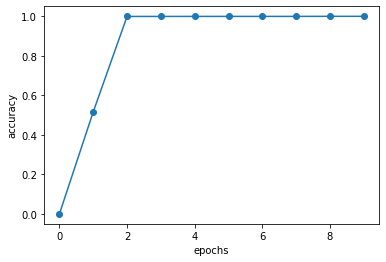

In [33]:
### AttentionSeq2seq 정확도 그래프
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

In [34]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

peeky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    peeky_acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 6[s] | 손실 2.86
| 에폭 1 |  반복 41 / 351 | 시간 12[s] | 손실 1.89
| 에폭 1 |  반복 61 / 351 | 시간 18[s] | 손실 1.78
| 에폭 1 |  반복 81 / 351 | 시간 25[s] | 손실 1.70
| 에폭 1 |  반복 101 / 351 | 시간 32[s] | 손실 1.57
| 에폭 1 |  반복 121 / 351 | 시간 38[s] | 손실 1.30
| 에폭 1 |  반복 141 / 351 | 시간 44[s] | 손실 1.16
| 에폭 1 |  반복 161 / 351 | 시간 51[s] | 손실 1.10
| 에폭 1 |  반복 181 / 351 | 시간 58[s] | 손실 1.07
| 에폭 1 |  반복 201 / 351 | 시간 64[s] | 손실 1.05
| 에폭 1 |  반복 221 / 351 | 시간 70[s] | 손실 1.04
| 에폭 1 |  반복 241 / 351 | 시간 77[s] | 손실 1.04
| 에폭 1 |  반복 261 / 351 | 시간 83[s] | 손실 1.03
| 에폭 1 |  반복 281 / 351 | 시간 89[s] | 손실 1.02
| 에폭 1 |  반복 301 / 351 | 시간 95[s] | 손실 1.01
| 에폭 1 |  반복 321 / 351 | 시간 101[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 107[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1971-11-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1973-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1983-03-03
---
Q Tuesday, November 22, 2016

| 에폭 6 |  반복 301 / 351 | 시간 119[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 127[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 135[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
val acc 99.980%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 8[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 16[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 24[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 32[s] | 손실 0.00
| 에폭 7 |  반복 101 

In [35]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

seq2seq_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    seq2seq_acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 7[s] | 손실 3.34
| 에폭 1 |  반복 41 / 351 | 시간 14[s] | 손실 1.95
| 에폭 1 |  반복 61 / 351 | 시간 21[s] | 손실 1.78
| 에폭 1 |  반복 81 / 351 | 시간 28[s] | 손실 1.70
| 에폭 1 |  반복 101 / 351 | 시간 35[s] | 손실 1.55
| 에폭 1 |  반복 121 / 351 | 시간 42[s] | 손실 1.27
| 에폭 1 |  반복 141 / 351 | 시간 49[s] | 손실 1.16
| 에폭 1 |  반복 161 / 351 | 시간 56[s] | 손실 1.12
| 에폭 1 |  반복 181 / 351 | 시간 63[s] | 손실 1.08
| 에폭 1 |  반복 201 / 351 | 시간 70[s] | 손실 1.06
| 에폭 1 |  반복 221 / 351 | 시간 77[s] | 손실 1.05
| 에폭 1 |  반복 241 / 351 | 시간 84[s] | 손실 1.04
| 에폭 1 |  반복 261 / 351 | 시간 91[s] | 손실 1.04
| 에폭 1 |  반복 281 / 351 | 시간 98[s] | 손실 1.03
| 에폭 1 |  반복 301 / 351 | 시간 105[s] | 손실 1.03
| 에폭 1 |  반복 321 / 351 | 시간 112[s] | 손실 1.03
| 에폭 1 |  반복 341 / 351 | 시간 119[s] | 손실 1.02
Q 10/15/94                     
T 1994-10-15
☒ 1999-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1999-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1999-01-11
---
Q Tuesday, November 22, 201

| 에폭 6 |  반복 301 / 351 | 시간 102[s] | 손실 0.98
| 에폭 6 |  반복 321 / 351 | 시간 109[s] | 손실 0.98
| 에폭 6 |  반복 341 / 351 | 시간 115[s] | 손실 0.98
Q 10/15/94                     
T 1994-10-15
☒ 1980-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1980-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1980-01-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1980-01-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1980-01-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1980-01-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1980-01-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1980-01-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1980-01-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1980-01-11
---
val acc 0.000%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 7 |  반복 21 / 351 | 시간 7[s] | 손실 0.98
| 에폭 7 |  반복 41 / 351 | 시간 13[s] | 손실 0.98
| 에폭 7 |  반복 61 / 351 | 시간 20[s] | 손실 0.98
| 에폭 7 |  반복 81 / 351 | 시간 27[s] | 손실 0.98
| 에폭 7 |  반복 101 /

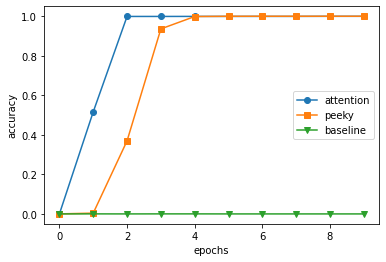

In [36]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o', label='attention')
plt.plot(x, peeky_acc_list, marker='s', label='peeky')
plt.plot(x, seq2seq_acc_list, marker='v', label='baseline')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

In [38]:
from ch08.visualize_attention import visualize

In [39]:
### 어텐션 가중치 시각화
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

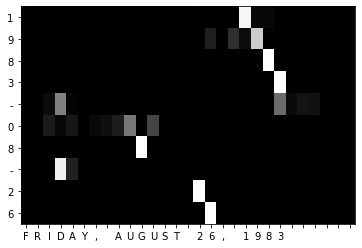

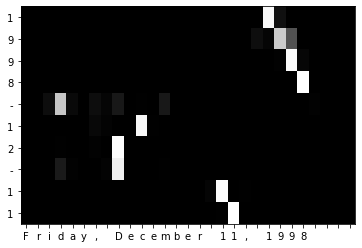

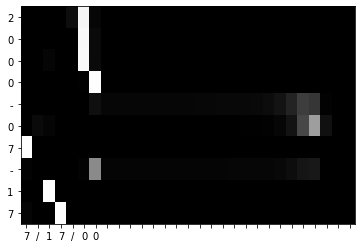

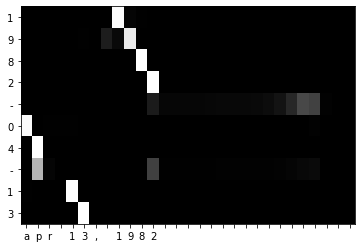

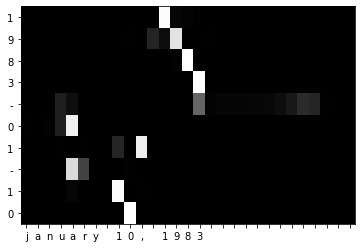

In [46]:
_idx=0

np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]
    
    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])
    
    attention_map = attention_map[:, ::-1]
    x = x[:, ::-1]
    
    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]
    
    visualize(attention_map, row_labels, column_labels)

In [41]:
np.random.randint(0, len(x_test))

4316

In [44]:
np.array(model.decoder.attention.attention_weights).shape

()

In [37]:
### 양방향 LSTM 구현: 입력데이터를 뒤집어서 LSTM에 넣으면 됨
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1, Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads
        
    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]
        
        out = np.concatenate((o1, o2), axis=2)
        return out
    
    def backward(self, dhs):
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]
        
        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs